## Instalando as dependências necessárias e lendo os arquivos processados

In [1]:
!pip install -q pyspark
!pip install matplotlib
!pip install seaborn

In [50]:
!pip install xgboost
!pip install lightgbm

In [93]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, current_date, concat_ws, datediff,date_format, explode, lit, min, max, row_number, sum as spark_sum, to_date, when
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
import lightgbm as lgb
import pandas as pd


spark = SparkSession.builder.master("local[*]").appName("Colab").getOrCreate()

In [3]:
df_offers_profile = spark.read.parquet("data/processed/offers_profile")
df_profile = spark.read.parquet("data/processed/profile")
df_offers = spark.read.parquet("data/processed/offers")


In [4]:
'''
Verificando se os arquivos foram carregados corretamente
'''
df_offers_profile.show(5)

+--------------------+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+-------------+-----------+--------------+--------+---------+--------------+----------+-------------------+----------------+----+--------+-------------+
|            offer_id|          account_id|age|credit_card_limit|gender|    average_amount|n_transactions|registered_on|days_since_register|  F|  M|  O|time_received|time_viewed|time_completed|duration|min_value|discount_value|offer_type|offer_name_adjusted|successful_offer|bogo|discount|informational|
+--------------------+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+-------------+-----------+--------------+--------+---------+--------------+----------+-------------------+----------------+----+--------+-------------+
|0b1e1539f2cc45b7b...|e1e4b47968ef42509...| 42|          51000.0|     M|            12.7

In [5]:
df_offers.show(5)

+--------------------+--------------------+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+----------------+
|          account_id|            offer_id|time_received|time_viewed|time_completed|duration|min_value|discount_value|   offer_type|offer_name_adjusted|successful_offer|
+--------------------+--------------------+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+----------------+
|0861b9ca31b741bb8...|f19421c1d4aa40978...|          0.0|        0.0|           1.5|     5.0|        5|             5|         bogo|         bogo_5_5_5|               1|
|4ecbfa77f6f84e779...|3f207df678b143eea...|          0.0|       -1.0|          -1.0|     4.0|        0|             0|informational|informational_0_0_4|               0|
|523e2d85f3d94eefb...|4d5c57ea9a6940dd8...|          0.0|       0.25|          1.75|     5.0|       10|            10|         bogo|       bogo_10_10_

In [6]:
df_profile.show(5)

+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+
|                  id|age|credit_card_limit|gender|    average_amount|n_transactions|registered_on|days_since_register|  F|  M|  O|
+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+
|c05652fa9d2c4fac9...| 62|          73000.0|     M|              3.89|             7|   2018-01-27|               2686|  0|  1|  0|
|6be0513109fe4d738...| 42|          57000.0|     M|             13.35|             3|   2018-06-13|               2549|  0|  1|  0|
|f5de20984950433d9...| 48|          75000.0|     M|20.228125000000002|            16|   2015-09-10|               3556|  0|  1|  0|
|9da3f2339b244229a...| 49|          36000.0|     F|            4.7175|             4|   2018-01-09|               2704|  1|  0|  0|
|fc58860830e648c9b...| 79|          64000.0|     M|              2.55|      

In [7]:
df_offers_profile.count(),df_offers.count(), df_profile.count()

(70701, 70701, 14825)

## Definição do Problema

**Visão Geral**

Desenvolver uma solução baseada em dados para otimizar a distribuição de cupons e ofertas aos clientes do iFood.

**Aspectos envolvidos**
* Diferentes tipos de ofertas disponíveis
* Diversos canais de marketing
* Variados perfis de consumo dos clientes
* Timing do envio das ofertas


**Objetivo**

1. Analisar os dados históricos de transações, ofertas e clientes
2. **Desenvolver uma técnica/modelo que auxilie na decisão de qual oferta
enviar para cada cliente**
3. Demonstrar o potencial impacto da sua solução no negócio


O objetivo principal é auxiliar na decisão de qual oferta enviar para cada cliente. Com base nos dados processados na etapa anterior, para cada usuário e oferta recebida, há uma indicador de sucesso da oferta (*successful_offer*), que apresenta valor 1 caso o usuário tenha aceitado a oferta, ou 0, caso contrário.

Dessa forma, o objetivo é prever se um cliente aceitará ou não uma oferta. Tratarei o problema como classificação binária.

Os dados de entrada são os dados de perfil do cliente (age,credit_card_limit,gender,average_amount,n_transactions,days_since_register), combinados com os dados da oferta (time_received,duration,min_value,discount_value,offer_type). O dado que queremos prever é *successful_offer*.

### Descrição detalhada


* **Tipo de problema de ML**: Classificação
* **Entrada(s)**: idade, limite do cartão de crédito, gênero, gasto médio por transação, número de transações, quantidade de tempo como cliente
* **Saída(s):** classificação automática se o cliente vai aceitar determinada oferta ou não
* **Métricas de avaliação**: *precision*, *recall*, *F1-Score*

### Dividindo a base em treino e teste por usuário de forma estratificada

Para **evitar vazamento de dados** e verificar a capacidade de generalização do modelo para usuários não vistos durante o treino, vou **separar os dados de treino e teste por usuários**. Se um usuário aparece no treino, todas as ofertas que ele recebeu/viu/completou aparecem apenas no treino, nada desse usuário estará no teste.

Para garantir que ao dividir os conjuntos por usuários tenhamos proporções parecidas de ofertas aceitas e rejeitadas, farei um split estratificado. Primeiro, vejamos se o dataset original está balanceado.

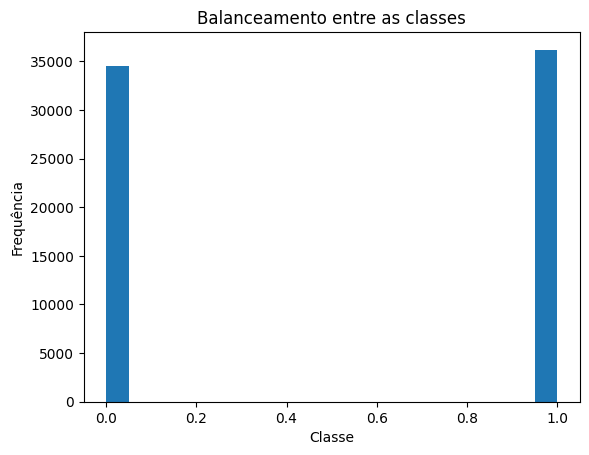

In [8]:
"""
Verificando se as classes no dataset estão balanceadas
"""
data_plot = df_offers_profile.select("successful_offer").rdd.flatMap(lambda x: x).collect()
plt.hist(data_plot, bins=20)
plt.xlabel("Classe")
plt.ylabel("Frequência")
plt.title("Balanceamento entre as classes")
plt.show()


In [11]:
'''
Vimos que as classes estão bem balanceadas. Ao separar os conjuntos por usuário, é preciso garantir que o balanceamento continue.
Primeiro, é preciso saber a proporção de aceite de ofertas por usuário (success_ratio).
'''
query_users = """
SELECT
    account_id,
    ROUND(SUM(CASE WHEN successful_offer = 1 THEN 1 ELSE 0 END) / COUNT(*), 4) AS success_ratio
FROM profile_offers
GROUP BY account_id
ORDER BY account_id
"""
df_offers_profile.createOrReplaceTempView("profile_offers")
users_success_rate = spark.sql(query_users)
users_success_rate.show(5)


+--------------------+-------------+
|          account_id|success_ratio|
+--------------------+-------------+
|0009655768c64bdeb...|          0.6|
|0011e0d4e6b944f99...|          0.6|
|0020c2b971eb4e918...|          0.6|
|0020ccbbb6d84e358...|         0.75|
|003d66b6608740288...|          0.6|
+--------------------+-------------+
only showing top 5 rows



Agora que já temos a proporção de ofertas aceitas por cada usuário, podemos dividir a base original de forma os subconjuntos tenham a mesmo proporção usuários que aceitam ofertas e usuários que rejeitam ofertas. A função abaixo faz isso.

In [9]:
def train_test_stratify(users_pd, train_split_percentage,seed=42):
  '''
  Para cada usuário, definir uma perfil pro success_ratio com base num limiar
  e.g: usuário com 40% de success_ratio tem perfil de aceitação média
  o objetivo é garantir que os perfis estejam balanceados nos conjuntos de treino e teste, já que vamos separar por usuário,
  para que esses conjuntos tenham usuários com todos os perfis
  '''
  train_users = []
  test_users = []

  # escolher usuários mantendo a proporção de perfis
  for profile in users_pd['acceptance_profile'].unique():
      profile_users = users_pd[users_pd['acceptance_profile'] == profile]
      train_sample = profile_users.sample(frac=train_split_percentage, random_state=seed)
      test_sample = profile_users.drop(train_sample.index)
      train_users.extend(train_sample['account_id'].tolist())
      test_users.extend(test_sample['account_id'].tolist())

  df_train = df_offers_profile.filter(col("account_id").isin(train_users))
  df_test = df_offers_profile.filter(col("account_id").isin(test_users))
  return df_train,df_test

In [13]:
'''
Definindo os perfis de usuário com base no success_ratio. Perfis: baixo, médio e alto.
'''
users_acceptance_profile = users_success_rate.withColumn("acceptance_profile",when(col("success_ratio") <= 0.33,"baixo").when(col("success_ratio") <= 0.66,"medio").otherwise("alto"))
users_pd = users_acceptance_profile.toPandas()

Vou separar 80% dos dados para treino e 20% para teste.

In [14]:
df_train,df_test = train_test_stratify(users_pd,0.8)

In [16]:
''' Verificando se há usuários em comum nos subconjuntos '''
common_users = df_train.select("account_id").intersect(df_test.select("account_id"))
common_users.count()

0

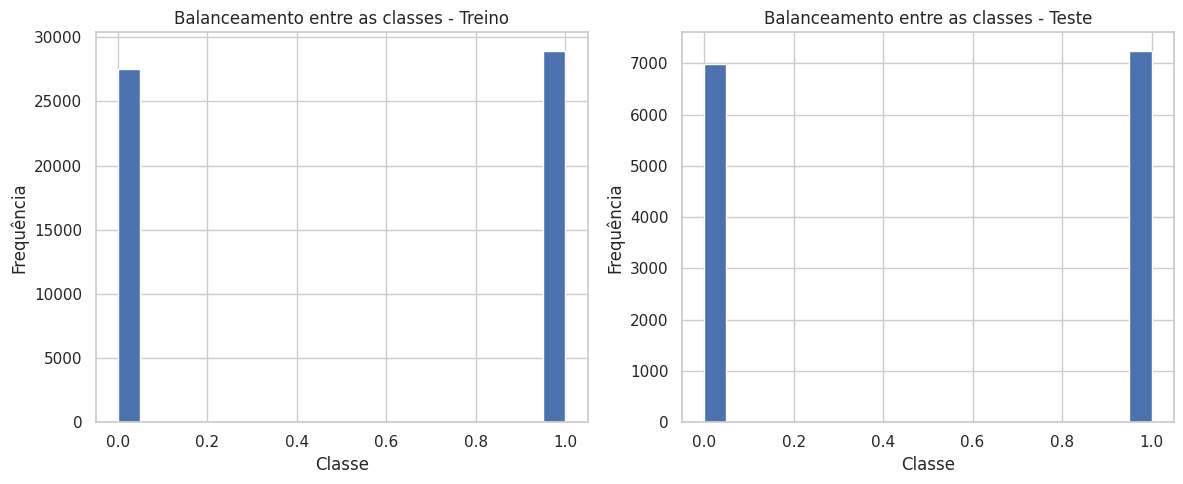

In [15]:
'''
Verificando se os conjuntos de treino e teste estão balanceados
'''

data_plot_test = df_test.select("successful_offer").rdd.flatMap(lambda x: x).collect()
data_plot_train = df_train.select("successful_offer").rdd.flatMap(lambda x: x).collect()
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(data_plot_train, bins=20)
axes[0].set_title("Balanceamento entre as classes - Treino")
axes[0].set_xlabel("Classe")
axes[0].set_ylabel("Frequência")

axes[1].hist(data_plot_test, bins=20)
axes[1].set_title("Balanceamento entre as classes - Teste")
axes[1].set_xlabel("Classe")
axes[1].set_ylabel("Frequência")

plt.tight_layout()
plt.show()


Não há interseção entre os conjuntos, e as classes estão balanceadas nos conjuntos de treino e teste, podemos seguir em frente.

Agora vou remover alguns dados e alterar outros para deixa-los prontos para serem usados nos modelos. Verificando os dados disponíveis:

In [28]:
df_train.columns

['offer_id',
 'account_id',
 'age',
 'credit_card_limit',
 'gender',
 'average_amount',
 'n_transactions',
 'registered_on',
 'days_since_register',
 'F',
 'M',
 'O',
 'time_received',
 'time_viewed',
 'time_completed',
 'duration',
 'min_value',
 'discount_value',
 'offer_type',
 'offer_name_adjusted',
 'successful_offer',
 'bogo',
 'discount',
 'informational']

Dentre as variáveis que vou remover estão: offer_id, offer_name_adjusted e offer_type, já que não preciso incluir o id ou nome da oferta, apenas as características específicas da oferta como min_value,duration,discount_value, e o tipo da oferta (bogo, discount, informational).

Vou remover gender, pois fiz o hot encoding desse dado; registered_on (ela representa o mesmo que 'days_since_register', eu teria redundância se mantivesse ambas); time_viewed e time_completed, pois esses dados podem estar inserindo informação futura sobre o evento, o que não é ideal. Vou manter apenas time_received que indica o horário de envio da oferta. *Successful_offer* é minha variável-alvo, então vou separa-la dos meus dados de entrada. Vou remover 'account_id' no futuro, pois já tenho outras caractecrísticas de perfil mais representativas.

Vou transformar 'account_id' em int a fim de facilitar etapas futuras como o *group k-fold*. Como há varios eventos relacionados ao mesmo usuário, novamente, para evitar *data leakage*, o ideal é que os dados de um mesmo usuário não apareçam no treino e no teste. Para garantir que isso não aconteça, ao treinar os modelos, usarei o *Group* *k-fold cross validation*. Nesse tipo de cross validation, os dados são separados por grupos, garantindo que um mesmo grupo não apareça no conjunto de treino e de validação.

Para identificar esses grupos, usarei o 'account_id'. Dessa forma, cada usuário representará um grupo diferente. Para facilitar o processamento, transformarei o 'account_id' pra um número inteiro, em vez de hash.

In [55]:
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank, col

#gerando account_ids inteiros
window = Window.orderBy("account_id")
df_train_transformed = df_train.withColumn("account_id_int", dense_rank().over(window))
#apagando colunas indesejadas
cols_to_drop = ['offer_id','account_id','offer_name_adjusted','offer_type','gender','registered_on','time_viewed', 'time_completed','successful_offer']
train_x = df_train_transformed.drop(*cols_to_drop)

#separando a variável-alvo dos dados de entrada
train_y = df_train.select("successful_offer")
test_x = df_test.drop(*cols_to_drop)
test_y = df_test.select("successful_offer")

#os grupos a serem usados na validação cruzada
groups = train_x.select("account_id_int").toPandas()
train_x = train_x.drop("account_id_int")

#verificando como estão os dados de treino
train_x.show(5)

+---+-----------------+------------------+--------------+-------------------+---+---+---+-------------+--------+---------+--------------+----+--------+-------------+
|age|credit_card_limit|    average_amount|n_transactions|days_since_register|  F|  M|  O|time_received|duration|min_value|discount_value|bogo|discount|informational|
+---+-----------------+------------------+--------------+-------------------+---+---+---+-------------+--------+---------+--------------+----+--------+-------------+
| 42|          51000.0|            12.706|             5|               3088|  0|  1|  0|         21.0|    10.0|       20|             5|   0|       1|            0|
| 44|          39000.0|2.4589999999999996|            10|               2749|  0|  1|  0|         24.0|    10.0|       20|             5|   0|       1|            0|
| 38|          76000.0|55.620909090909095|            11|               2716|  0|  1|  0|         21.0|    10.0|       20|             5|   0|       1|            0|
| 60

In [56]:
df_train_transformed.select("account_id").distinct().count(),df_train_transformed.select("account_id_int").distinct().count()

(11856, 11856)

In [57]:
#verificando como estão os dados de teste
test_x.show(5)

+---+-----------------+------------------+--------------+-------------------+---+---+---+-------------+--------+---------+--------------+----+--------+-------------+
|age|credit_card_limit|    average_amount|n_transactions|days_since_register|  F|  M|  O|time_received|duration|min_value|discount_value|bogo|discount|informational|
+---+-----------------+------------------+--------------+-------------------+---+---+---+-------------+--------+---------+--------------+----+--------+-------------+
| 39|          32000.0|            9.6225|             8|               2826|  1|  0|  0|         14.0|    10.0|       20|             5|   0|       1|            0|
| 32|          40000.0| 3.216842105263158|            19|               4197|  0|  1|  0|          0.0|    10.0|       20|             5|   0|       1|            0|
| 55|          57000.0|            16.034|             5|               2852|  0|  1|  0|         21.0|    10.0|       20|             5|   0|       1|            0|
| 68

In [58]:
#convertendo para Pandas dataframe para uso posterior
train_x_pd = train_x.toPandas()
train_y_pd = train_y.toPandas().values.ravel()
test_x_pd = test_x.toPandas()
test_y_pd = test_y.toPandas().values.ravel()

### Escolhendo os modelos pros experimentos

Alguns modelos de classificação serão testados sob o conjunto de dados de treino acima a fim de analisarmos qual terá o melhor desempenho e qual usaremos como modelo final para fazer inferência sobre o conjunto de teste.

Como métrica para avaliarmos os modelos, usaremos F1-Score - uma média harmônica entre a precisão e recall. A precisão indica a capacidade do classificador de não rotular como positiva uma amostra que é negativa. Para o caso de recomendar ofertas, um modelo com precisão alta ajudaria a evitar recomendar uma oferta que o usuário vai rejeitar.

O *recall* quantifica a capacidade do modelo de identificar todas as instâncias relevantes dentro de um conjunto de dados. No nosso contexto, um *recall* alto indica que há menos chances de um usuário perder boas ofertas. Dessa forma, um bom F1-Score pode indicar o equilíbrio entre dar boas recomendações e não deixar de recomendar possíveis boas ofertas.

Aplicaremos validação cruzada sobre o conjunto de teste usando 3 folds. Dois tipos de scaler serão usados para normalizar os dados: o StandardScaler e o RobustScaler, que é menos sensível a outliers. Em nosso dataset, temos muitos outliers na variável *average_amount*.

Para a tarefa de classificação binária, escolhi modelos clássicos, muito utilizados pra esse tipo de tarefa como SVM e LR, e  outros modelos robustos que já usei em outros contextos e funcionaram bem. Os modelos a serem testados são: Regressão Logística (LR), K-Nearest Neighbors (KNN), DecisionTrees (CART), RandomForest (RF), XGBoost Classifier (XGB), LightGBM(LGB) e Support Vector Machine (SVM).


### Usando Group K-Fold para evitar vazamento de dados no cross-validation

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import warnings

warnings.filterwarnings("ignore")
seed_xgb = 42

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(objective="binary:logistic",eval_metric="logloss",use_label_encoder=False,random_state=seed_xgb),
    "LGBMClassifier": LGBMClassifier(objective='binary', metric='logloss'),
    "SVM": SVC()
}

scalers = {"StandardScaler": StandardScaler(), "RobustScaler": RobustScaler()}
cv_folds = 3
cv = GroupKFold(n_splits=cv_folds)
groups_list = groups['account_id_int'].tolist()
cv_results_all = []

for scaler_name, scaler in scalers.items():
    for model_name, model in models.items():
        pipeline = Pipeline([('scaler', scaler), ('clf', model)])
        scores = cross_val_score(pipeline, train_x_pd, train_y_pd, cv=cv, groups=groups_list, scoring='f1')

        result_temp = {"scaler": scaler_name,"model": model_name,"F1-score-mean": scores.mean(),"F1-score-std": scores.std()}
        for i, score in enumerate(scores, start=1):
            result_temp[f"F1-score-{i}"] = score

        cv_results_all.append(result_temp)
        print(f"{scaler_name}-{model_name}: F1-Scores: {scores}, Média: {scores.mean():.4f}, Desvio Padrão: {scores.std():.4f}")

cv_results_all = pd.DataFrame(cv_results_all)


StandardScaler-LogisticRegression: F1-Scores: [0.85290494 0.85187377 0.8528408 ], Média: 0.8525, Desvio Padrão: 0.0005
StandardScaler-KNeighborsClassifier: F1-Scores: [0.8452584  0.84945753 0.84291968], Média: 0.8459, Desvio Padrão: 0.0027
StandardScaler-DecisionTreeClassifier: F1-Scores: [0.8331345  0.82543964 0.82267717], Média: 0.8271, Desvio Padrão: 0.0044
StandardScaler-RandomForestClassifier: F1-Scores: [0.87903266 0.8778335  0.8729383 ], Média: 0.8766, Desvio Padrão: 0.0026
StandardScaler-XGBClassifier: F1-Scores: [0.87750914 0.87730706 0.87179487], Média: 0.8755, Desvio Padrão: 0.0026
[LightGBM] [Info] Number of positive: 19226, number of negative: 18426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 37652, numbe

Verificando a configuração que resultou no melhor F1-Score:

In [72]:
cv_results_all

,scaler,model,F1-score-mean,F1-score-std,F1-score-1,F1-score-2,F1-score-3
0,StandardScaler,LogisticRegression,0.852540,0.000472,0.852905,0.851874,0.852841
1,StandardScaler,KNeighborsClassifier,0.845879,0.002705,0.845258,0.849458,0.842920
2,StandardScaler,DecisionTreeClassifier,0.827084,0.004425,0.833134,0.825440,0.822677
3,StandardScaler,RandomForestClassifier,0.876601,0.002636,0.879033,0.877834,0.872938
4,StandardScaler,XGBClassifier,0.875537,0.002647,0.877509,0.877307,0.871795
5,StandardScaler,LGBMClassifier,0.880132,0.002528,0.880639,0.882944,0.876815
6,StandardScaler,SVM,0.876668,0.002960,0.878606,0.878913,0.872485
7,RobustScaler,LogisticRegression,0.850727,0.000114,0.850668,0.850885,0.850627
8,RobustScaler,KNeighborsClassifier,0.851239,0.002918,0.850407,0.855156,0.848154
9,RobustScaler,DecisionTreeClassifier,0.826904,0.002692,0.830640,0.825671,0.824400


In [78]:
cv_results_all.loc[cv_results_all['F1-score-mean'].idxmax()]

,12
scaler,RobustScaler
model,LGBMClassifier
F1-score-mean,0.880685
F1-score-std,0.002241
F1-score-1,0.882233
F1-score-2,0.882306
F1-score-3,0.877516


Com a validação cruzada, o modelo que apresentou o melhor resultado foi o LGBMClassifier com RobustScaler para normalização dos dados. O F1-score médio desse modelo foi 0.8806.

### Ajuste no Modelo usando GridSearch

Agora que já sabemos o melhor modelo e o scaler mais apropriado, vamos usar o GridSearch para otimização de hiperparâmetros.

In [83]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

lgbm = lgb.LGBMClassifier(objective="binary", metric="binary_logloss", random_state=42)
cvk = GroupKFold(n_splits=cv_folds)

grid = GridSearchCV(estimator=lgbm,param_grid=param_grid,cv=cvk,scoring="f1", verbose=1,n_jobs=-1)
grid.fit(train_x_pd, train_y_pd, groups=groups['account_id_int'].tolist())

print(f"Melhores parâmetros: {grid.best_params_}")
print(f"Melhor F1-score: {grid.best_score_:.4f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Number of positive: 28938, number of negative: 27540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 56478, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512377 -> initscore=0.049516
[LightGBM] [Info] Start training from score 0.049516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [87]:
best_model = grid.best_estimator_#modelo com os melhores parametros encontrados durante a busca
y_pred = best_model.predict(test_x_pd) #testando no conjunto separado anteriormente
print(classification_report(test_y_pd, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      6980
           1       0.85      0.91      0.88      7243

    accuracy                           0.87     14223
   macro avg       0.88      0.87      0.87     14223
weighted avg       0.87      0.87      0.87     14223



### Feature Importance

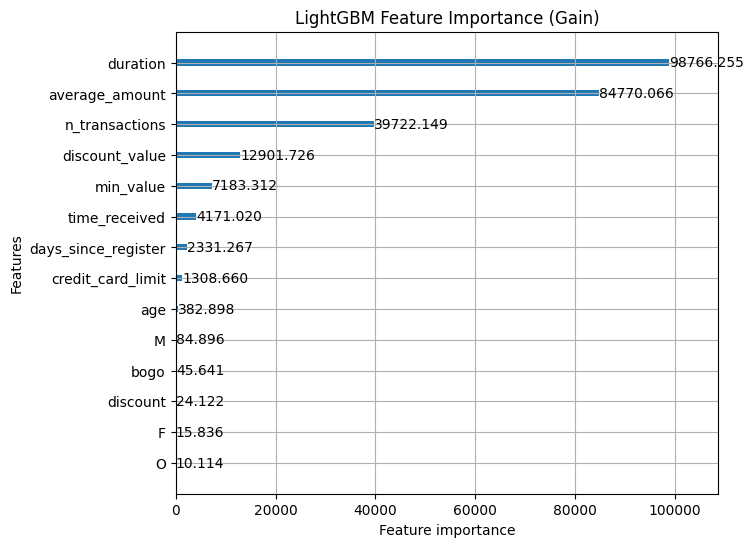

In [91]:
lgb.plot_importance(best_model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

Ao analisar as features que mais impactaram nas decisões, vemos que a duração da oferta, junto com o valor médio por transação foram as que mais impactaram.

## Resultado Final

O modelo que apresentou o melhor desempenho foi o LBMClassifier, com *F1-Score* de 0.87 sobre os dados do conjunto de teste. Isso indica que há um equilírio entre as métricas de precisão e recall.

Olhando para precisão da classe 1 (ofertas aceitas), vemos que das ofertas que o modelo previu que o usuário aceitaria, 85% delas foram de fato aceitas. O que indica que o modelo está conseguindo identificar a maior parte das boas ofertas pra um usuário.

Quanto ao *recall* da classe de ofertas aceitas, vemos que o modelo identificou 91% das ofertas que o usuário de fato aceitaria. Isso indica que o modelo não está recomendando muitas ofertas que não seriam de interesse do usuário.

## Potencial impacto nos negócios

* Recomendar apenas ofertas com alta chance de aceitação pode aumentar a taxa de conversão e melhorar a experiência do usuário, que não será incomodado com ofertas que não são de seu interesse.

* Evitar o envio de ofertas irrelevantes pode reduzir gastos com divulgação/marketing.

* Receber ofertas personalizadas pode aumentar a satisfação do cliente e contribuir pra fidelização do mesmo